In [1]:
import numpy as np
import random
import time
import matplotlib
import matplotlib.pyplot as plt


class JobShop:
    # This class is the environment of Job shop problem

    bool_generate_random_jssp = None
    number_job = None
    number_machine = None
    number_features = None

    # the lower limit of one position of job 's processing time.
    time_low = None
    # the upper limit of one position of job 's processing time.
    time_high = None

    # Matrix of processing time, M_processing_time[i,j] is the processing time of job i 's position j.
    M_processing_time = None
    # Matrix of processing time, M_processing_order[i,j] is the machine restrain of job i 's position j.
    M_processing_order = None
    M_start_time = None
    M_end_time = None
    X_schedule_plan = None
    schedule_line = None

    def __init__(self, number_machine, number_job, time_low, time_high, bool_random):
        self.number_job = number_job
        self.bool_generate_random_jssp = random
        self.number_machine = number_machine
        self.time_low = time_low
        self.time_high = time_high
        self.schedule_line = []
        self.GenerateRandomProblem()

    def Get_Possible_Job_Position(self):
        # ergodic the schedule_line, and return the possible position to produce of jobs

        job_position_list = [0 for i in range(self.number_job)]
        for job_id, job_position in self.schedule_line:
            if job_position < self.number_machine-1:
                job_position_list[job_id] = job_position+1
            else:
                job_position_list[job_id] = -1

        return [[i, job_position_list[i]] for i in range(len(job_position_list))]

    def Get_Features(self, possible_job_position):
        # return the features of current state

        featrues = []
        for job_id, job_position in possible_job_position:
            f_item = self.GetFeature(job_id, job_position)
            featrues.append(f_item)

        return featrues

    def Step(self, action=None):
        # be called in main function
        # input action and return state score and done
        # action: choose a job to process.
        # state:

        done = False
        if action == None:
            self.MeasurementAction(self.schedule_line)
            possible_pob_position = self.Get_Possible_Job_Position()
            state = np.array(self.Get_Features(possible_pob_position))
            score = 0
        else:

            job_position_list = [0 for i in range(self.number_job)]
            for job_id, job_position in self.schedule_line:
                if job_position < self.number_machine-1:
                    job_position_list[job_id] = job_position+1
                else:
                    job_position_list[job_id] = -1
            if job_position_list[action] == -1:
                done = True
                canchoose = [[i, job_position_list[i]] for i in range(
                    self.number_job) if job_position_list[i] != -1]
                action = canchoose[0]
            else:
                action = [action, job_position_list[action]]

            self.schedule_line.append(action)
            self.MeasurementAction(self.schedule_line)
            # self.PlotResult()
            score = np.max(self.M_end_time)

            possible_pob_position = self.Get_Possible_Job_Position()
            state = np.array(self.Get_Features(possible_pob_position))

        state = [np.reshape(state[i], (1, 2)) for i in range(self.number_job)]

        return state, score, done

    def GenerateRandomProblem(self):
        # Generate the jobshop problem
        # random problem or a stable problem

        if self.bool_generate_random_jssp == True:
            a = list(range(self.time_low, self.time_high))
            p = []
            for k in range(self.number_job):
                p.append(random.sample(a, self.number_machine))
            self.M_processing_time = np.array(p)

            a = list(range(self.number_machine))
            r = []
            for k in range(self.number_job):
                r.append(random.sample(a, self.number_machine))
            self.M_processing_order = np.array(r)

            sum_time_of_job = np.sum(self.M_processing_time, axis=1)

            for i in range(self.number_job):
                for j in range(i+1, self.number_job):
                    if sum_time_of_job[i] > sum_time_of_job[j]:
                        a = np.copy(self.M_processing_time[j, :])
                        self.M_processing_time[j,
                                               :] = self.M_processing_time[i, :]
                        self.M_processing_time[i, :] = a
                        sum_time_of_job[i], sum_time_of_job[j] = sum_time_of_job[j], sum_time_of_job[i]

            sum_time_of_mach = [[i, 0] for i in range(self.number_machine)]
            for i in range(self.number_job):
                for j in range(self.number_machine):
                    sum_time_of_mach[self.M_processing_order[i, j]
                                     ][1] += self.M_processing_time[i, j]

            for i in range(self.number_machine):
                for j in range(i+1, self.number_machine):
                    if sum_time_of_mach[i][1] > sum_time_of_mach[j][1]:
                        sum_time_of_mach[i], sum_time_of_mach[j] = sum_time_of_mach[j], sum_time_of_mach[i]

            nr = np.zeros((self.number_job, self.number_machine), dtype=int)-1
            for i in range(self.number_machine):
                nr[self.M_processing_order == i] = sum_time_of_mach[i][0]

            sum_time_of_mach = [[i, 0] for i in range(self.number_machine)]
            for i in range(self.number_job):
                for j in range(self.number_machine):
                    sum_time_of_mach[self.M_processing_order[i, j]
                                     ][1] += self.M_processing_time[i, j]

            self.M_processing_order = nr
        else:
            self.M_processing_order = np.array(
                [[1, 3, 0, 2], [0, 2, 1, 3], [3, 1, 2, 0], [1, 3, 0, 2], [0, 1, 2, 3]])
            self.M_processing_time = np.array([[18, 20, 21, 17], [18, 26, 15, 16], [
                17, 18, 27, 23], [18, 21, 25, 15], [22, 29, 28, 21]])

    def MeasurementAction(self, action_history):
        # measurement the action and return the makespan

        M_start_time = np.zeros((self.number_machine, self.number_job))
        M_end_time = np.zeros((self.number_machine, self.number_job))

        timeline_machine = np.zeros((self.number_machine), dtype=int)
        index_machine = np.zeros((self.number_machine), dtype=int)
        timeline_job = np.zeros((self.number_job), dtype=int)
        index_job = np.zeros((self.number_job), dtype=int)
        X_schedule_plan = np.zeros(
            (self.number_machine, self.number_job, 2), dtype=int)

        for job_id, job_position in action_history:
            machine_id = self.M_processing_order[job_id, job_position]

            current_start_time = max(
                timeline_machine[machine_id], timeline_job[job_id])
            current_end_time = current_start_time + \
                self.M_processing_time[job_id, job_position]

            timeline_machine[machine_id], timeline_job[job_id] = current_end_time, current_end_time
            current_index = index_machine[machine_id]
            M_start_time[machine_id, current_index] = current_start_time
            M_end_time[machine_id, current_index] = current_end_time
            X_schedule_plan[machine_id, current_index, :] = [
                job_id, job_position]
            index_machine[machine_id] += 1
            index_job[job_id] += 1

        self.M_start_time = M_start_time
        self.M_end_time = M_end_time
        self.X_schedule_plan = X_schedule_plan
        return np.max(M_end_time)

    def PlotResult(self, num=0):
        # plot function for the gant map

        colorbox = ['yellow', 'whitesmoke', 'lightyellow',
                    'khaki', 'silver', 'pink', 'lightgreen', 'orange', 'grey', 'r', 'brown']

        for i in range(100):
            colorArr = ['1', '2', '3', '4', '5', '6', '7',
                        '8', '9', 'A', 'B', 'C', 'D', 'E', 'F']
            color = ""
            for i in range(6):
                color += colorArr[random.randint(0, 14)]
            colorbox.append("#"+color)

        fig = plt.figure(figsize=(7, 4))
        for i in range(self.number_machine):
            # number_of_mashine:
            for j in range(self.number_job):
                # number_of_job:
                # % read the start time point
                mPoint1 = self.M_start_time[i, j]
                mPoint2 = self.M_end_time[i, j]  # % read the end time point
                mText = i + 1.5  # % read the index of machine
                PlotRec(mPoint1, mPoint2, mText)  # % plot subfunction
                Word = str(self.X_schedule_plan[i, j, 0]+1) + '.' + str(
                    self.X_schedule_plan[i, j, 1]+1)  # % read machine id

                x1, x2, x3, x4 = mPoint1, mPoint2, mPoint2, mPoint1
                y1, y2, y3, y4 = mText-0.8, mText-0.8, mText, mText
                plt.fill([x1, x2, x3, x4], [y1, y2, y3, y4],
                         color=colorbox[self.X_schedule_plan[i, j, 0]])
                plt.text(0.5*mPoint1+0.5*mPoint2-3.5, mText-0.5, Word)
        plt.xlabel('Time')
        plt.ylabel('Machine')
        plt.tight_layout()
        plt.savefig('gant.png')
        plt.close()

    def Print_info(self):
        # print the problem infomation

        print('order')
        print(self.M_processing_order)
        print('time')
        print(self.M_processing_time)
        print('start time')
        print(self.M_start_time)
        print('end time')
        print(self.M_end_time)
        print('X')
        print(self.X_schedule_plan)

    def GetFeature(self, job_id, job_position):
        # get the feature of one position of one job 
        # readers can change the feature to get a more powerful model 

        # raw features
        machine_id = self.M_processing_order[job_id, job_position]
        job_time_need = np.sum(self.M_processing_time, axis=1)
        current_time_use = self.M_processing_time[job_id, job_position]

        machine_endtime = np.max(self.M_end_time, axis=1)
        job_endtime = np.sum(self.M_processing_time[job_id, :job_position])
        job_alltime = np.sum(self.M_processing_time[job_id, :])

        if job_position == 0:
            frac_currentend_othermachineave = 0.5
            frac_currentend_otherjobave = 0.5
            frac_currentendplusthisposition_othermachineave = 1
            schedule_finish_station = 0

            frac_jobposition_jobtime = 1
            frac_jobposition_totaltime = 1
        else:
            frac_currentend_othermachineave = (
                0.1+machine_endtime[machine_id]) / (0.1+np.average(machine_endtime))
            frac_currentendplusthisposition_othermachineave = (
                machine_endtime[machine_id]+current_time_use)/np.average(machine_endtime)
            schedule_finish_station = np.count_nonzero(
                self.M_end_time)/self.number_machine/self.number_job

            frac_currentend_otherjobave = (0.1+job_endtime) / (0.1+job_alltime)
            frac_jobposition_jobtime = current_time_use/job_time_need[job_id]
            frac_jobposition_totaltime = current_time_use/np.sum(job_time_need)

        # feature choose
        features = []
        # current features
        features.append(frac_currentend_othermachineave)
        features.append(frac_currentend_otherjobave)

        # features.append(frac_currentendplusthisposition_othermachineave)
        # features.append(schedule_finish_station)
        # # stable features
        # features.append(frac_jobposition_jobtime)
        # features.append(frac_jobposition_totaltime)

        self.number_features = len(features)

        if job_position == -1:
            features = [-1] * self.number_features

        return features


def PlotRec(mPoint1, mPoint2, mText):
    # sub function to plot a box in figure

    vPoint = np.zeros((4, 2))
    vPoint[0, :] = [mPoint1, mText-0.8]
    vPoint[1, :] = [mPoint2, mText-0.8]
    vPoint[2, :] = [mPoint1, mText]
    vPoint[3, :] = [mPoint2, mText]
    plt.plot([vPoint[0, 0], vPoint[1, 0]], [vPoint[0, 1], vPoint[1, 1]], 'k')
    plt.plot([vPoint[0, 0], vPoint[2, 0]], [vPoint[0, 1], vPoint[2, 1]], 'k')
    plt.plot([vPoint[1, 0], vPoint[3, 0]], [vPoint[1, 1], vPoint[3, 1]], 'k')
    plt.plot([vPoint[2, 0], vPoint[3, 0]], [vPoint[2, 1], vPoint[3, 1]], 'k')


if __name__ == "__main__":
    # main function used in debug

    problem = JobShop(4, 5, 15, 30, bool_random = False)
    # print(problem.MeasurementAction([]))
    #print(problem.MeasurementAction([[0, 0], [1, 0], [2, 0], [3, 0], [4, 0],[0, 1], [1, 1], [2, 1], [3, 1], [4, 1]]))
    print(problem.Get_Possible_Job_Position())

[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]]


In [2]:
# -*- coding: utf-8 -*-
import random
from collections import deque

import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.layers import Dense, Input,Conv1D,Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import JobShop

EPISODES = 100   #tar


class DQNAgent:
    # class for deep q learning agent 
    
    def __init__(self, state_size, action_size, number_job, number_feature):
        self.state_size = state_size
        self.action_size = action_size
        self.number_job = number_job
        self.number_feature = number_feature
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 0.9  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        #self.model = self._build_subproblem_model() # build the model 
        self.model = self._easymodel()

    def _build_subproblem_model(self):
        # to build the whole model for jobshop  

        basic_model = self._submodel()

        output_list = []
        input_list = []
        for i in range(self.number_job):
            input_list.append(Input(shape=(self.number_feature,)))
            output_list.append(basic_model(input_list[i]))

        concatenated = tf.keras.layers.concatenate(output_list)
        out = Dense(self.action_size, activation='linear')(concatenated)
        model = Model(input_list, out)
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def _submodel(self):
        # the sub model called by function  _build_subproblem_model

        model = Sequential(name='basic_model')
        model.add(Dense(24, input_dim=self.number_feature, activation='relu'))
        model.add(Dense(24, input_dim=self.number_feature, activation='relu'))
        model.add(Dense(24, input_dim=self.number_feature, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def _easymodel(self):
        # the easy ann model, not used in this method 
        input1=Input(shape=(10,1),name="input_1")
        conv1_1=Conv1D(16,2,padding="same",strides=1,activation="relu")(input1)
        flatten=Flatten()(conv1_1)
        dense2=Dense(100,activation="relu")(flatten)
        dense=Dense(self.action_size, activation='relu')(dense2)
        model=tf.keras.models.Model(inputs=input1,outputs=dense)
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # remember the information of this step

        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # let the agent make a decision
        # choose a job to process in current state

        if np.random.rand() >= self.epsilon:
            return random.randrange(self.action_size)

        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        # replay the history and train the model
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            history=self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return history.history["loss"]

    def load(self, name):
        # load the model
        self.model.load_weights(name)

    def save(self, name):
        # save the model
        self.model.save_weights(name)


if __name__ == "__main__":

    # agent.load("./save/jobshop-dqn.h5")
    number_job = 5
    number_machine = 4
    number_feature = 2
    state_size = number_job * number_feature
    action_size = number_job
    agent = DQNAgent(state_size, action_size, number_job, number_feature)
    batch_size = number_job * number_machine * 10

    history_loss= []
    Reward=[]
    successnumber = 0
    
    Conuter=[]

    # the main loop for each job shop problem 
    for e in range(EPISODES):
        
        problem = JobShop.JobShop(number_machine, number_job, 15, 30, False)
        state, score, done = problem.Step()
        #Change the state shape to satisify the input of our defined model 
        state=np.reshape(state,(1,10,1))
        action_list = []
        oldscore = 0
        score = 0

        # the sub loop for each step of the problem 
        for time in range(number_job*number_machine):

            action = agent.act(state)
            next_state, score, done = problem.Step(action)
            next_state=np.reshape(next_state,(1,10,1))
            reward = oldscore - score + 15 if not done else -1000
            Reward.append(reward)
            oldscore = score
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
        

            if done:
                if time >= number_job * number_machine-1:
                    successnumber += 1
                    Conuter.append([time,successnumber])
                    
                    problem.PlotResult()
                    problem.Print_info()
                break

            # record the history 
            action_list.append(action)

        if len(agent.memory) > batch_size:
            loss=agent.replay(batch_size)
            history_loss.append(loss)
        if e % 10 == 0:
            print("loop : {}/{},  score: {} success: {} / 10, e: {:.2}"
                  .format(e, EPISODES, score, successnumber, agent.epsilon))
            print(action_list, len(action_list))
            #f = open('log/logs', 'a')
            #f.close()
            successnumber = 0

            agent.save("./save/jobshop-dqn.h5")


        

loop : 0/100,  score: 159.0 success: 0 / 10, e: 0.9
[4, 4, 4, 4, 0, 0, 0, 0] 8
loop : 10/100,  score: 159.0 success: 0 / 10, e: 0.9
[4, 4, 4, 4, 0, 0, 0, 0, 3] 9
loop : 20/100,  score: 159.0 success: 0 / 10, e: 0.9
[4, 4, 4, 4, 0, 0, 0, 0] 8
loop : 30/100,  score: 177.0 success: 0 / 10, e: 0.86
[0, 0, 0, 0, 2, 2, 2, 2, 4, 4] 10
loop : 40/100,  score: 129.0 success: 0 / 10, e: 0.82
[0, 2, 0, 3, 0, 0, 2, 2, 1, 2] 10
loop : 50/100,  score: 102.0 success: 0 / 10, e: 0.78
[2, 3, 4, 3, 0, 3, 3, 0, 0] 9
loop : 60/100,  score: 259.0 success: 0 / 10, e: 0.74
[3, 2, 3, 3, 4, 2, 3, 4, 0, 0, 0, 0, 2, 2] 14
loop : 70/100,  score: 111.0 success: 0 / 10, e: 0.7
[2, 3, 2, 2, 2, 3, 3] 7
loop : 80/100,  score: 109.0 success: 0 / 10, e: 0.67
[2, 1, 3, 1, 2, 3, 3, 2, 4, 1, 2, 3, 0] 13
loop : 90/100,  score: 193.0 success: 0 / 10, e: 0.64
[2, 1, 3, 2, 3, 3, 3, 0, 4, 1, 4, 2, 2, 0, 0, 0] 16


In [3]:
from keras.utils import plot_model
plot_model(agent.model, to_file='model.png')
agent.model.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 16)            48        
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               16100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 16,653
Trainable params: 16,653
Non-trainable params: 0
_________________________________________

In [27]:
#plt.plot(history_loss)

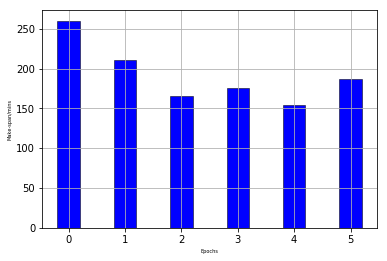

In [26]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(6)
    plt.bar(index, [260,211,166,175,154,187],width=0.4,color="blue",linewidth=0.5,edgecolor="black")
    plt.xlabel('Epochs', fontsize=5)
    plt.ylabel('Make-span/mins', fontsize=5)
    plt.grid()
    plt.show()
plot_bar_x()